
# CS133 Term Project — Linear Regression Model (Hospital Revenue)

**Dataset:** `2022-23 financial and utilization report.csv`  
**Goal:** Use California hospital financial & utilization data to analyze revenue patterns and build a **Linear Regression** model to predict hospital revenue.

## Five Key Project Questions

1. **Which counties earn the most hospital revenue?**  
2. **How does revenue change each quarter?**  
3. **Which type of hospital earns more?**  
4. **What factors affect hospital revenue the most?**  
5. **Do larger hospitals generate more revenue?**  

In this notebook will:
- Import and explore the dataset (EDA)
- Engineer useful features (year, quarter, etc.)
- Prepare data with **one-hot encoding** and **scaling**
- Train and evaluate a **Linear Regression** model
- Use metrics like **RMSE**, **MAE**, and **R²** to evaluate performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv("2022-23 financial and utilization report.csv")
df.head()

,index,FAC_NO,FAC_NAME,YEAR_QTR,BEG_DATE,END_DATE,OP_STATUS,COUNTY_NAME,HSA,HFPA,...,TOT_OUT_VIS_CC,GROS_INPAT_REV_CC,GROS_OUTPAT_REV_CC,CONTR_ADJ_CC,OTHR_DEDUCT_CC,CAP_PREM_REV_CC,NET_PAT_REV_CC,QA_FEES,QA_SUPPL_PAY,MNGD_CARE_QA_PAY
0,1,106580996,ADVENTIST HEALTH AND RIDEOUT,20234,10/01/2023,12/31/2023,Open,Yuba,02 - Golden Empire,227,...,0,0,0,0,0,0,0,0,0,0
1,2,106150788,ADVENTIST HEALTH BAKERSFIELD,20234,10/01/2023,12/31/2023,Open,Kern,09 - Central,617,...,0,0,0,0,0,0,0,0,0,0
2,3,106171049,ADVENTIST HEALTH CLEARLAKE,20234,10/01/2023,12/31/2023,Open,Lake,01 - Northern California,115,...,0,0,0,0,0,0,0,0,0,0
3,4,106150706,ADVENTIST HEALTH DELANO,20234,10/01/2023,12/31/2023,Open,Kern,09 - Central,617,...,0,0,0,0,0,0,0,0,0,0
4,5,106190323,ADVENTIST HEALTH GLENDALE,20234,10/01/2023,12/31/2023,Open,Los Angeles,11 - Los Angeles,909,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Drop unused "index" column from earlier exports
if "index" in df.columns:
    df = df.drop(columns=["index"])

print("Shape:", df.shape)
df.info()

Shape: (3506, 133)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3506 entries, 0 to 3505
Columns: 133 entries, FAC_NO to MNGD_CARE_QA_PAY
dtypes: int64(119), object(14)
memory usage: 3.6+ MB


In [4]:
missing = df.isna().sum()
missing[missing > 0]

TEACH_RURL    2754
dtype: int64

In [5]:
df["YEAR_QTR"] = df["YEAR_QTR"].astype(int)
df["YEAR"] = df["YEAR_QTR"] // 10
df["QTR"] = df["YEAR_QTR"] % 10

df[["YEAR_QTR", "YEAR", "QTR"]].head()

,YEAR_QTR,YEAR,QTR
0,20234,2023,4
1,20234,2023,4
2,20234,2023,4
3,20234,2023,4
4,20234,2023,4


# Exploratory Data Analysis (EDA)

## Q1 — Which counties earn the most hospital revenue?

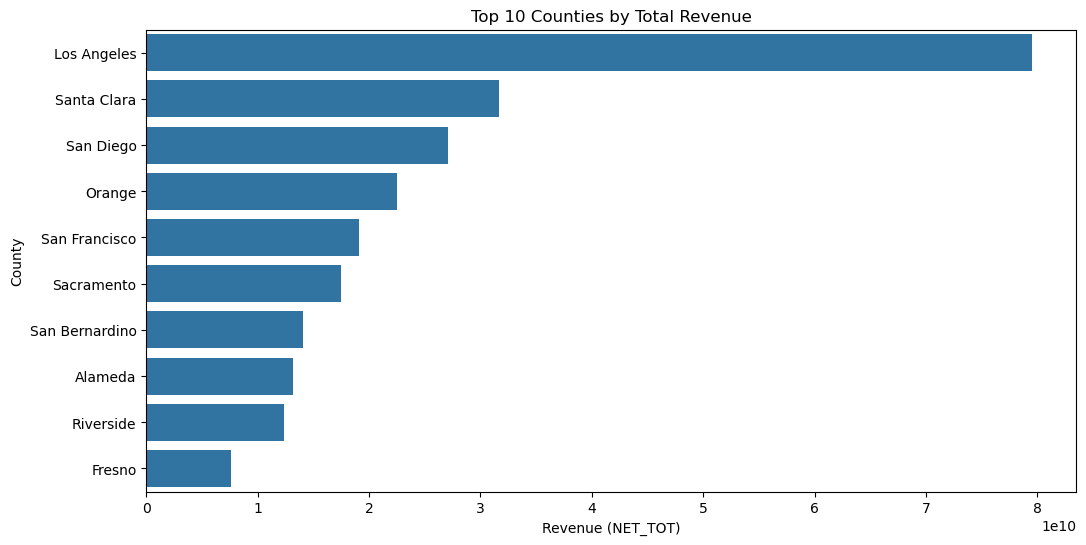

COUNTY_NAME
Los Angeles       79518195819
Santa Clara       31645553045
San Diego         27054025729
Orange            22535140271
San Francisco     19057202333
Sacramento        17481690090
San Bernardino    14027322195
Alameda           13158523506
Riverside         12334037076
Fresno             7572136613
Name: NET_TOT, dtype: int64

In [6]:
top_counties = df.groupby("COUNTY_NAME")["NET_TOT"].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(y=top_counties.head(10).index, x=top_counties.head(10).values)
plt.title("Top 10 Counties by Total Revenue")
plt.xlabel("Revenue (NET_TOT)")
plt.ylabel("County")
plt.show()

top_counties.head(10)

Los Angeles County generates by far the highest hospital revenue at $79.5 billion, followed by Santa Clara ($31.6B) and San Diego ($27.0B). These counties lead due to large populations, high patient volume, and major medical centers.

## Q2 — How does revenue change each quarter?

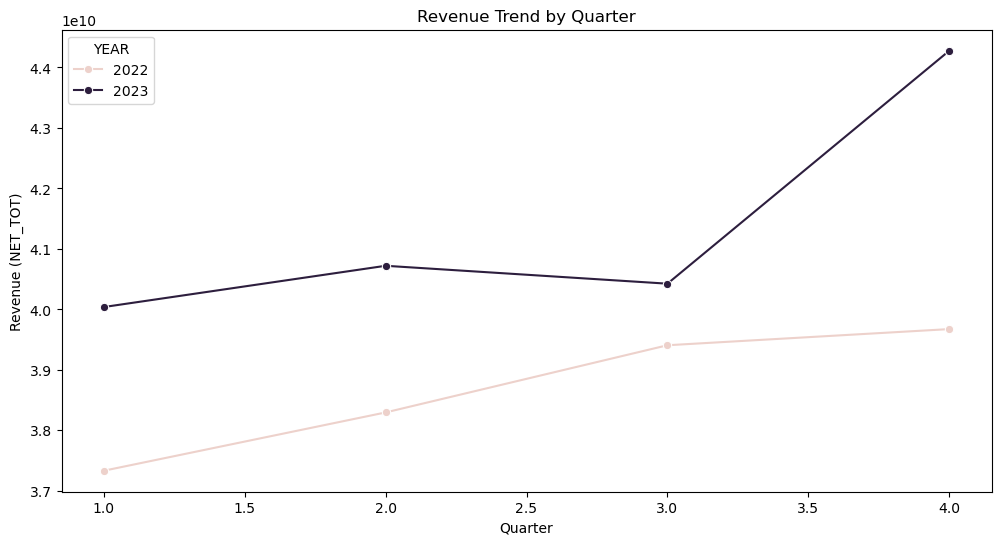

,YEAR,QTR,NET_TOT
0,2022,1,37332741710
1,2022,2,38296568904
2,2022,3,39407469671
3,2022,4,39674539673
4,2023,1,40039351792


In [7]:
rev_q = df.groupby(["YEAR","QTR"])["NET_TOT"].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=rev_q, x="QTR", y="NET_TOT", hue="YEAR", marker="o")
plt.title("Revenue Trend by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Revenue (NET_TOT)")
plt.show()

rev_q.head()

Revenue steadily increases across the quarters in both 2022 and 2023, with Q4 showing the highest revenue each year. This pattern suggests strong seasonal effects, where hospital revenue peaks at the end of the year.

## Q3 — Which type of hospital earns more?

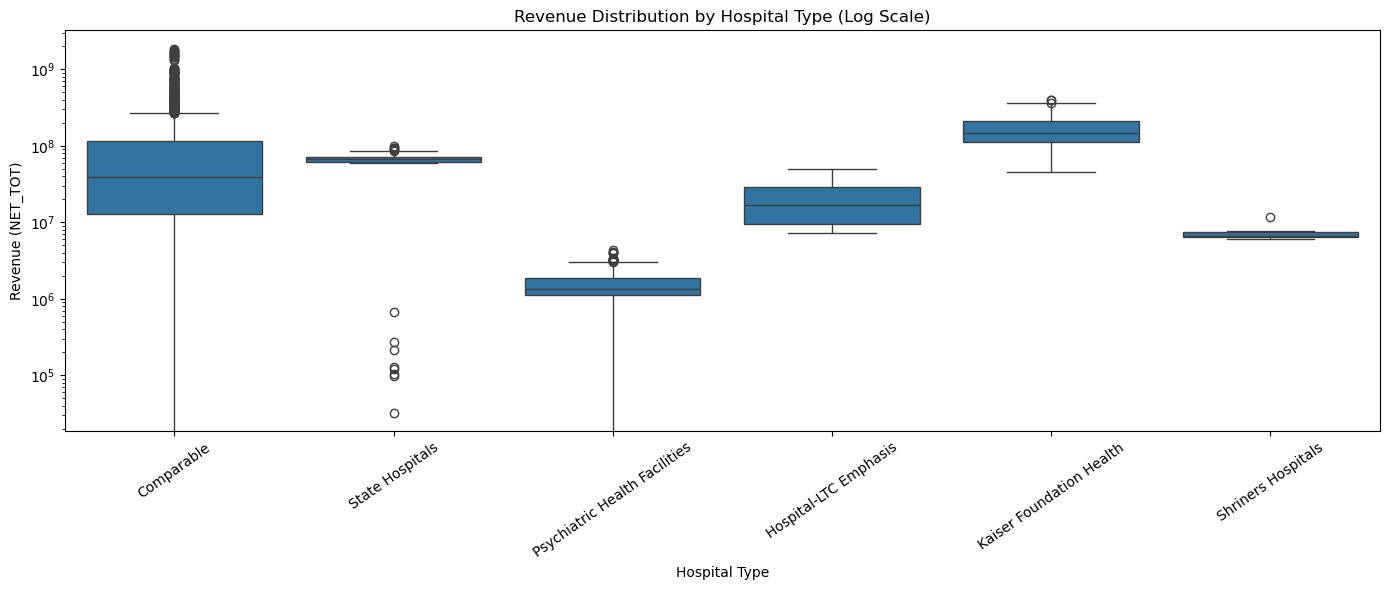

TYPE_HOSP
Kaiser Foundation Health         1.724539e+08
Comparable                       9.375661e+07
State Hospitals                  6.011194e+07
Hospital-LTC Emphasis            2.092200e+07
Shriners Hospitals               7.422330e+06
Psychiatric Health Facilities    1.564682e+06
Name: NET_TOT, dtype: float64

In [8]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="TYPE_HOSP", y="NET_TOT")
plt.yscale("log")
plt.xticks(rotation=35)
plt.title("Revenue Distribution by Hospital Type (Log Scale)")
plt.xlabel("Hospital Type")
plt.ylabel("Revenue (NET_TOT)")
plt.tight_layout()
plt.show()

df.groupby("TYPE_HOSP")["NET_TOT"].mean().sort_values(ascending=False)

Kaiser Foundation Health hospitals generate the highest revenue on average, followed by Comparable hospitals. Psychiatric Health Facilities and Shriners Hospitals earn significantly less, indicating that larger integrated systems drive the majority of hospital revenue in California.

## Q4 — What factors affect hospital revenue the most? (Correlation Heatmap)

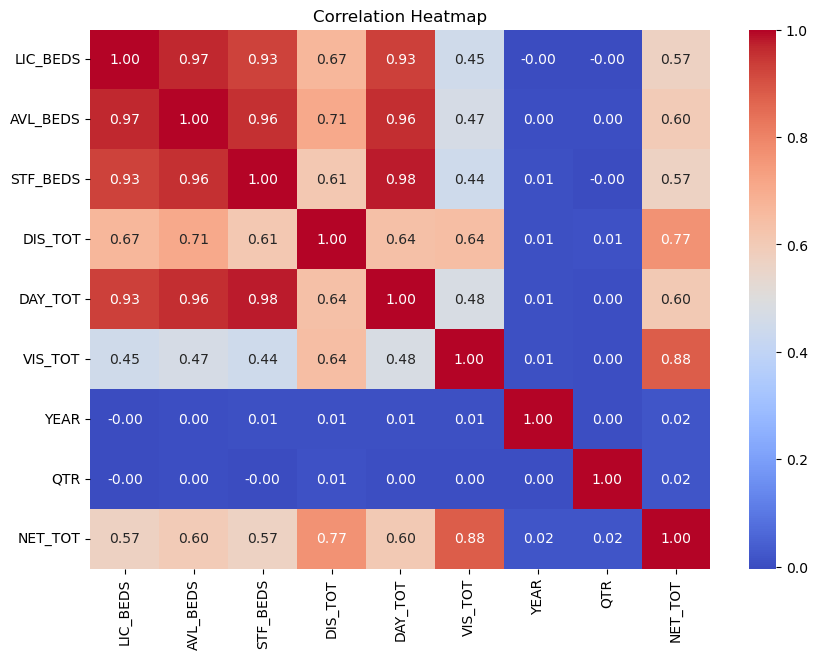

NET_TOT     1.000000
VIS_TOT     0.878571
DIS_TOT     0.766952
DAY_TOT     0.604497
AVL_BEDS    0.599176
LIC_BEDS    0.571161
STF_BEDS    0.567225
YEAR        0.019168
QTR         0.016237
Name: NET_TOT, dtype: float64

In [9]:
# Select numeric features including target
corr_cols = ["LIC_BEDS","AVL_BEDS","STF_BEDS","DIS_TOT","DAY_TOT","VIS_TOT","YEAR","QTR","NET_TOT"]
corr_cols = [c for c in corr_cols if c in df.columns]

plt.figure(figsize=(10,7))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

df[corr_cols].corr()["NET_TOT"].sort_values(ascending=False)

Revenue is most strongly influenced by patient volume, with total visits (VIS_TOT) showing the highest correlation (0.88), followed by total discharges (0.77) and patient days (0.60). Bed capacity measures such as AVL_BEDS and LIC_BEDS also have moderate impact, while YEAR and QTR contribute very little on their own.

## Q5— Do larger hospitals generate more revenue?

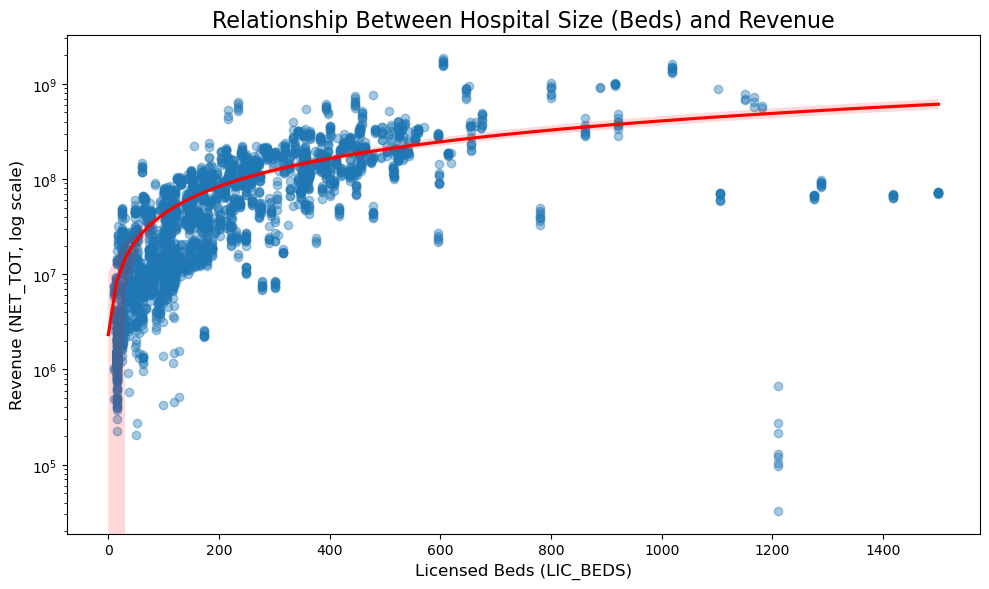

,LIC_BEDS,NET_TOT
LIC_BEDS,1.000000,0.571161
NET_TOT,0.571161,1.000000


In [10]:
plt.figure(figsize=(10,6))
sns.regplot(data=df, x="LIC_BEDS", y="NET_TOT", scatter_kws={"alpha":0.4}, line_kws={"color":"red"})

plt.yscale("log")    
plt.xlabel("Licensed Beds (LIC_BEDS)", fontsize=12)
plt.ylabel("Revenue (NET_TOT, log scale)", fontsize=12)
plt.title("Relationship Between Hospital Size (Beds) and Revenue", fontsize=16)
plt.tight_layout()
plt.show()

df[["LIC_BEDS", "NET_TOT"]].corr()

Yes — licensed beds show a moderate positive correlation with revenue (r = 0.57), meaning larger hospitals generally earn more. However, the wide spread in the data suggests that factors like patient volume and hospital type also play major roles.

In [11]:
# Select Safe Features
safe_numeric = [
    "LIC_BEDS", "AVL_BEDS", "STF_BEDS",
    "DIS_TOT", "DAY_TOT", "VIS_TOT",
    "YEAR", "QTR"
]

safe_categorical = [
    "COUNTY_NAME", "TYPE_HOSP", "TYPE_CNTRL", "OP_STATUS"
]

df = df.dropna(subset=["NET_TOT"])
X = df[safe_numeric + safe_categorical]
y = df["NET_TOT"]

In [12]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [13]:
# Preprocessing: One-Hot Encoding + Scaling
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, safe_numeric),
        ("cat", categorical_transformer, safe_categorical)
    ]
)

In [14]:
# Build & Train Linear Regression Model
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [15]:
# Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2  = r2_score(y_test, y_pred)
acc = r2 * 100

print("MAE :", mae)
print("MSE :", mse)
print("RMSE:", rmse)
print("R² Score:", r2)
print("Accuracy %:", acc)

MAE : 30889749.004252236
MSE : 2312865069689737.0
RMSE: 48092255.818268046
R² Score: 0.8061734839607729
Accuracy %: 80.61734839607729


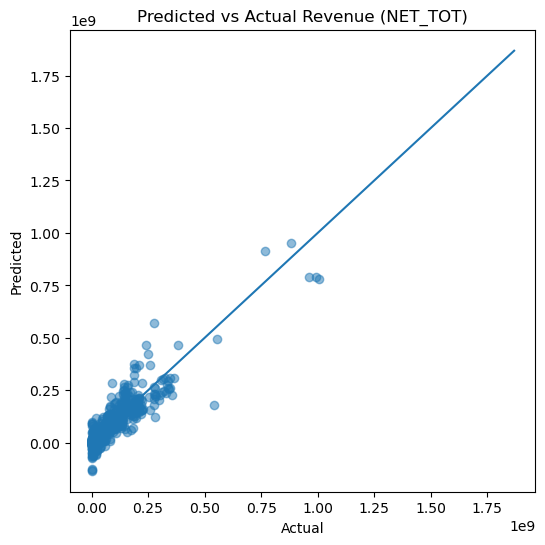

In [16]:
# Predicted vs Actual Scatter Plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.title("Predicted vs Actual Revenue (NET_TOT)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [17]:
# 10-Fold Cross Validation
cv_scores = cross_val_score(
    model, X_train, y_train, cv=10, scoring="r2"
)

print("10-Fold Cross-Validation R² Scores:", cv_scores)
print("Mean R²:", cv_scores.mean())

10-Fold Cross-Validation R² Scores: [0.89319648 0.94272749 0.83869596 0.78585524 0.87410884 0.77828326
 0.93295911 0.65079536 0.87689076 0.91586107]
Mean R²: 0.8489373579894599
